By: David Cui B00788648

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras import models, layers, optimizers, datasets, utils, losses
from scipy import ndimage

Using TensorFlow backend.


Load data and check if first 1024 data is balanced.

The first 1024 data are relatively distributed, not perfectly even, but I can say the first 1024 data are balanced. So, I will use them for training.

In [2]:
(x_train, y_train),(x_test, y_test) = datasets.mnist.load_data()
x_train = x_train[0:1024]
y_train = y_train[0:1024]

count = [0] * 10
for (i) in range (1024):
    count[y_train[i]]+=1
print(count)

[100, 120, 101, 95, 108, 92, 95, 122, 90, 101]


# MLP
I start with MLP model. It is the same as the MLP model shown in class and in the manuscript.

In [3]:
x_train_mlp = x_train.reshape(1024, 784)/255
x_test_mlp = x_test.reshape(10000, 784)/255
y_train_mlp = utils.to_categorical(y_train, 10)
y_test_mlp = utils.to_categorical(y_test, 10)

inputs = layers.Input(shape=(784,))
x = layers.Dense(128, activation='relu')(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(loss=losses.categorical_crossentropy,
             optimizer='Nadam', metrics=['accuracy'])

history_mlp = model.fit(x_train_mlp, y_train_mlp, batch_size=128, epochs=20, 
          validation_data = (x_test_mlp, y_test_mlp))

score_mlp = model.evaluate(x_test_mlp, y_test_mlp)

Train on 1024 samples, validate on 10000 samples
Epoch 1/20
1024/1024 [==============================] - 1s 1ms/step - loss: 1.9899 - acc: 0.3740 - val_loss: 1.4204 - val_acc: 0.5001
Epoch 2/20
1024/1024 [==============================] - 0s 271us/step - loss: 1.1024 - acc: 0.6357 - val_loss: 0.8051 - val_acc: 0.7632
Epoch 3/20
1024/1024 [==============================] - 0s 288us/step - loss: 0.8078 - acc: 0.7314 - val_loss: 0.5838 - val_acc: 0.8232
Epoch 4/20
1024/1024 [==============================] - 0s 277us/step - loss: 0.3998 - acc: 0.8906 - val_loss: 0.5321 - val_acc: 0.8247
Epoch 5/20
1024/1024 [==============================] - 0s 276us/step - loss: 0.2584 - acc: 0.9268 - val_loss: 0.4921 - val_acc: 0.8473
Epoch 6/20
1024/1024 [==============================] - 0s 281us/step - loss: 0.2254 - acc: 0.9326 - val_loss: 0.4632 - val_acc: 0.8614
Epoch 7/20
1024/1024 [==============================] - 0s 290us/step - loss: 0.1178 - acc: 0.9688 - val_loss: 0.3683 - val_acc: 0.8914
E

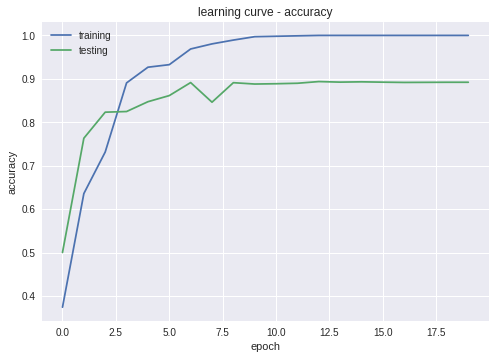

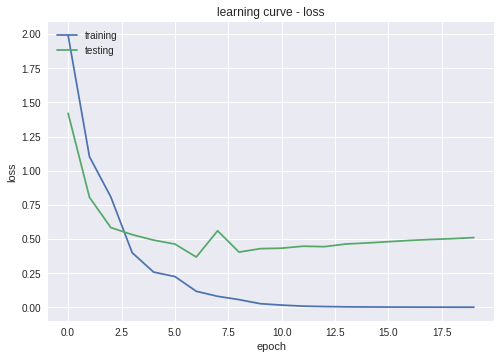

Test Accuracy:  0.8921


In [4]:
#training and testing acuracy
plt.plot(history_mlp.history['acc'])
plt.plot(history_mlp.history['val_acc'])
plt.title('learning curve - accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'testing'], loc='upper left')
plt.show()

#training and testing loss
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('learning curve - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'testing'], loc='upper left')
plt.show()

print('Test Accuracy: ', score_mlp[1])

From the learning curve for the MLP model, I see some interesting observations. The model memorizes the 1024 training data and reach 100% accuracy at 13th epoch. The model also generalizes testing data with about 89.2% accuracy.

There is a spike in the testing curve, which is unexpected, since accuracy should be improving. I am not sure what the reason for the spike is.

If I just look at the accuracy curve, everything seems fine, but the loss curve shows that the model testing loss is increasing from the 8th epoch. However, the test accuracy improves slighty in epochs after the 8th epoch. So, the loss curve suggests that the model is starting to be overfitted from the 8th epoch, but the accuracy curve does not suggest so.

It is also worth noting that test accuracy starts 50%, showing that the model can generalize the 10000 test data with some ok accuracy from the 1st epoch.

# CNN
Next, I train the CNN model. The class example uses sequential model and the manuscript model uses functional model, but the layers and hyper-parameters are the same. Here I use the sequential model.

In [9]:
x_train_cnn = x_train.reshape(1024, 28, 28, 1)/255
x_test_cnn = x_test.reshape(10000, 28, 28, 1)/255
y_train_cnn = utils.to_categorical(y_train, 10)
y_test_cnn = utils.to_categorical(y_test, 10)

model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.Adadelta(),
              metrics=['accuracy'])

history_cnn = model.fit(x_train_cnn, y_train_cnn, batch_size=128, epochs=20,
          verbose=1, validation_data=(x_test_cnn, y_test_cnn))

score_cnn = model.evaluate(x_test_cnn, y_test_cnn, verbose=1)

Train on 1024 samples, validate on 10000 samples
Epoch 1/20
1024/1024 [==============================] - 1s 1ms/step - loss: 1.9620 - acc: 0.3564 - val_loss: 1.3697 - val_acc: 0.6710
Epoch 2/20
1024/1024 [==============================] - 1s 673us/step - loss: 1.2524 - acc: 0.6025 - val_loss: 1.0016 - val_acc: 0.6794
Epoch 3/20
1024/1024 [==============================] - 1s 659us/step - loss: 0.9043 - acc: 0.7139 - val_loss: 0.5808 - val_acc: 0.8186
Epoch 4/20
1024/1024 [==============================] - 1s 659us/step - loss: 0.5650 - acc: 0.8242 - val_loss: 0.4612 - val_acc: 0.8522
Epoch 5/20
1024/1024 [==============================] - 1s 650us/step - loss: 0.4460 - acc: 0.8574 - val_loss: 0.4179 - val_acc: 0.8644
Epoch 6/20
1024/1024 [==============================] - 1s 639us/step - loss: 0.3729 - acc: 0.8809 - val_loss: 0.3684 - val_acc: 0.8864
Epoch 7/20
1024/1024 [==============================] - 1s 653us/step - loss: 0.3055 - acc: 0.9014 - val_loss: 0.3096 - val_acc: 0.9066
E

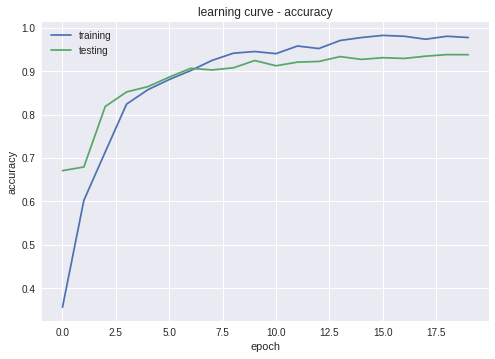

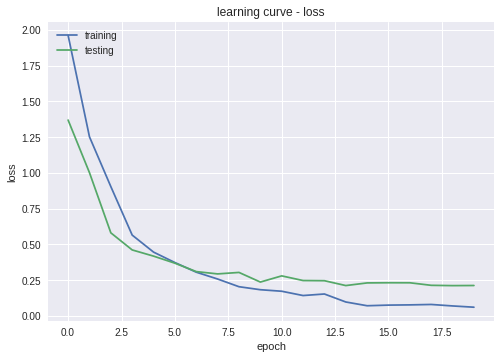

Test Accuracy:  0.938


In [10]:
#training and testing acuracy
plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])
plt.title('learning curve - accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'testing'], loc='upper left')
plt.show()

#training and testing loss
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('learning curve - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'testing'], loc='upper left')
plt.show()

print('Test Accuracy: ', score_cnn[1])

The CNN model took more time to train than the MLP model. On Google GPU, CNN took about 2x more time to train than MLP.

When I trained it with my laptop GPU, CNN training time for each epoch is in ms, while MLP epoch time are in us, CNN takes about 100x more time. (not shown here)

CNN model test accuracy is 93.8% after 20th epoch, which is higher than MLP model's 89.2% accuracy, showing that the convolution filter layers and pooling layers help with improving accuracy.

Both loss and accuracy curves are always improving over the 20 epochs, so there is no sign of overfitting, unlike the MLP model, which showed overfitting.

For some reason, the testing curve starts out with higher accuracy than the training curve, probably because the training data is 1024 entries while the testing data contained 10000 data points.

The curve is also not very smooth, so the learning is fluctuating slightly.

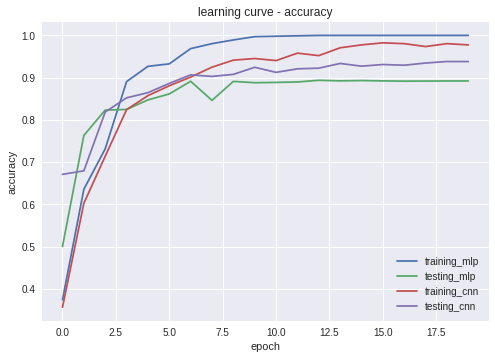

In [11]:
#plot both model curve together
#training and testing acuracy for MLP and CNN model
plt.plot(history_mlp.history['acc'])
plt.plot(history_mlp.history['val_acc'])
plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])
plt.title('learning curve - accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training_mlp', 'testing_mlp','training_cnn', 'testing_cnn'], loc='lower right')
plt.show()

When plotting the accuracy curves together, I can see that MLP model memorized the training data while CNN model did not memorize the training data yet, because MLP is at 100% accuracy for training data and CNN is not at 100% yet. However, if we look at the testing accuracy, then CNN model generalizes better than the MLP model.

In conclusion, I'd say that the CNN model took longer to train and more epochs to memorize the training data, and this CNN model offers higher accuracy for the MNIST problem than this MLP model.

# VGG16
VGG16 require at least 32x32x3 shaped input, so I need to enlarge the 28x28 MNIST image. VGG16 default is 224x224, but I tried that and that takes too much memory and is too slow. So I enlarge MNIST by 2, to have 56x56.

I need to have 3 channels. I got 3 channels by simply duplicating the original greyscale channel to 3 channels.

I also reduce the test data size, to improve speed.

In [4]:
(x_train, y_train),(x_test, y_test) = datasets.mnist.load_data()

x_train = x_train[0:1024]
y_train = y_train[0:1024]
x_train = ndimage.zoom(x_train, (1, 2, 2))
x_train = np.stack((x_train,)*3, -1)
y_train = utils.to_categorical(y_train, 10)

x_test = x_test[0:1024]
x_test = ndimage.zoom(x_test, (1, 2, 2))
x_test = np.stack((x_test,)*3, -1)

y_test = y_test[0:1024]
y_test = utils.to_categorical(y_test, 10)

x_train = x_train/255
x_test = x_test/255

print(x_train.shape)
print(x_test.shape)

(1024, 56, 56, 3)
(1024, 56, 56, 3)


I imported pre-trained VGG16 model without dense layer, I can see that this model don't have the Flatten layer and the 3 dense layer, so I'll add them. There are 10 classes, from 0-9.

With the help of: https://github.com/keras-team/keras/issues/4465

In [3]:
from keras.applications.vgg16 import VGG16

model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

input = layers.Input(shape=(56,56,3))

# add dense layers
output_vgg16_conv = model_vgg16_conv(input)
x = layers.Flatten(name='flatten')(output_vgg16_conv)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(10, activation='softmax')(x)

# my model
model = models.Model(inputs=input, outputs=x)

#only train dense layers
for layer in model_vgg16_conv.layers:
    layer.trainable = False

# compile the model
model.compile(loss=losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

#train
history_vgg = model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1,
          validation_data = (x_test, y_test))

Train on 1024 samples, validate on 1024 samples
Epoch 1/20
1024/1024 [==============================] - 4s 4ms/step - loss: 2.8682 - acc: 0.2012 - val_loss: 1.7388 - val_acc: 0.4453
Epoch 2/20
1024/1024 [==============================] - 2s 2ms/step - loss: 1.2645 - acc: 0.6631 - val_loss: 0.8687 - val_acc: 0.7285
Epoch 3/20
1024/1024 [==============================] - 2s 2ms/step - loss: 0.6449 - acc: 0.8018 - val_loss: 0.5798 - val_acc: 0.8027
Epoch 4/20
1024/1024 [==============================] - 2s 2ms/step - loss: 0.4576 - acc: 0.8535 - val_loss: 0.4969 - val_acc: 0.8320
Epoch 5/20
1024/1024 [==============================] - 2s 2ms/step - loss: 0.3588 - acc: 0.8770 - val_loss: 0.3928 - val_acc: 0.8711
Epoch 6/20
1024/1024 [==============================] - 2s 2ms/step - loss: 0.2593 - acc: 0.9277 - val_loss: 0.3717 - val_acc: 0.8867
Epoch 7/20
1024/1024 [==============================] - 2s 2ms/step - loss: 0.2078 - acc: 0.9365 - val_loss: 0.3784 - val_acc: 0.8760
Epoch 8/20
102

The above training result shows that VGG16 model is doing pretty good.

I must make a comment here. I initially enlarged data to 224x224x3, and that was a bad idea, because it was incredibly slow to compute any operation due to the large size, and it crushes my laptop, making me use Google GPU, and then frequently cause Google GPU to be out of memory. Also when the input is 224x224, the VGG16 model doesn't learn for some reason. The accuracy is always around 10%. Even though I tried some different optimizers such as sgd, adam, etc. The accuracy still remained at 10%.

Then, I suddenly realized that I don't have to use 224x224x3, I can just use 56x56x3, and after I made the change. Everything became so great. The computing and the training are all very fast now. And the model is learning now.

So, my observation is that large input size cause the model to not learn for some reason, and smaller input size causes the model to start learning and the accuracy improves.

1024/1024 [==============================] - 2s 2ms/step
Test Accuracy:  0.916015625


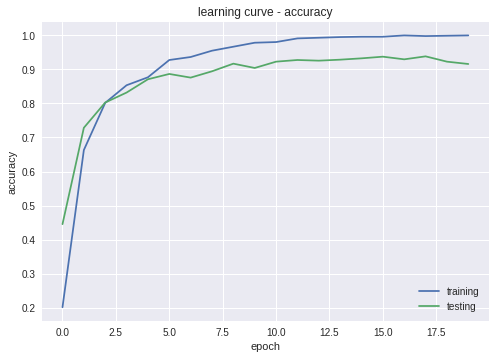

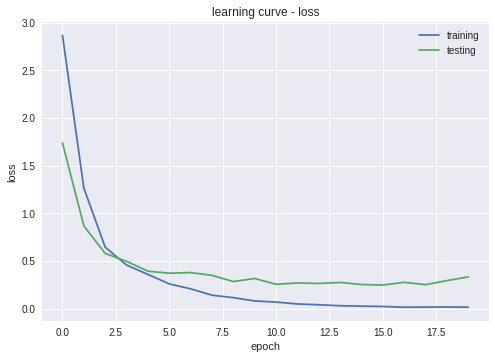

In [4]:
score_vgg = model.evaluate(x_test, y_test)
print('Test Accuracy: ', score_vgg[1])

#training and testing acuracy
plt.plot(history_vgg.history['acc'])
plt.plot(history_vgg.history['val_acc'])
plt.title('learning curve - accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'testing'], loc='lower right')
plt.show()

#training and testing loss
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('learning curve - loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'testing'], loc='upper right')
plt.show()

At epoch 20, seems like the model is overfitted, the accuracy curve is going down and loss curve is going up.

CNN seems to have slightly more accuracy than the VGG16 model. 93.8 vs 91.6. But the maximum is actually similar if we drop the overfit part.

VGG16 model took longer time to train than CNN model. 600 us vs 2ms.

Considering that the VGG16 model's convolutional layers are pre-trained, this 91% accuracy shows that the lower level filters are similar and pre-trained lower layers can be used for other problems.

Now, I will train the topmost convolutional layer and the dense layers.

In [30]:
for i, layer in enumerate(model_vgg16_conv.layers):
   print(i, layer.name)

0 input_5
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [0]:
from keras.applications.vgg16 import VGG16

model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

input = layers.Input(shape=(56,56,3))

# add dense layers
output_vgg16_conv = model_vgg16_conv(input)
x = layers.Flatten(name='flatten')(output_vgg16_conv)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(10, activation='softmax')(x)

# my model
model = models.Model(inputs=input, outputs=x)

#only train dense layers
for layer in model_vgg16_conv.layers[0:15]:
  layer.trainable = False
for layer in model_vgg16_conv.layers[15:]:
  layer.trainable = True

# compile the model
model.compile(loss=losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 56, 56, 3)         0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 4096)              2101248   
_________________________________________________________________
dense_11 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_12 (Dense)             (None, 10)                40970     
Total params: 33,638,218
Trainable params: 26,002,954
Non-trainable params: 7,635,264
________________________________________________________

In [7]:
# train
history_vgg2 = model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1,
          validation_data = (x_test, y_test))

Train on 1024 samples, validate on 1024 samples
Epoch 1/20
1024/1024 [==============================] - 5s 5ms/step - loss: 2.8222 - acc: 0.1270 - val_loss: 2.3030 - val_acc: 0.1152
Epoch 2/20
1024/1024 [==============================] - 2s 2ms/step - loss: 2.5144 - acc: 0.0781 - val_loss: 2.3021 - val_acc: 0.1104
Epoch 3/20
1024/1024 [==============================] - 2s 2ms/step - loss: 2.3016 - acc: 0.1143 - val_loss: 2.3014 - val_acc: 0.0996
Epoch 4/20
1024/1024 [==============================] - 2s 2ms/step - loss: 2.3006 - acc: 0.1191 - val_loss: 2.3007 - val_acc: 0.0996
Epoch 5/20
1024/1024 [==============================] - 2s 2ms/step - loss: 2.2992 - acc: 0.1191 - val_loss: 2.3003 - val_acc: 0.0996
Epoch 6/20
1024/1024 [==============================] - 2s 2ms/step - loss: 2.2986 - acc: 0.1191 - val_loss: 2.3002 - val_acc: 0.0996
Epoch 7/20
1024/1024 [==============================] - 2s 2ms/step - loss: 2.2985 - acc: 0.1191 - val_loss: 2.2999 - val_acc: 0.0996
Epoch 8/20
102

The model isn't learning when I am training the top conv layers. I decide to try again with a new optimizer, sgd.

In [13]:
from keras.applications.vgg16 import VGG16

model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

input = layers.Input(shape=(56,56,3))

# add dense layers
output_vgg16_conv = model_vgg16_conv(input)
x = layers.Flatten(name='flatten')(output_vgg16_conv)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(10, activation='softmax')(x)

# my model
model = models.Model(inputs=input, outputs=x)

#only train dense layers
for layer in model_vgg16_conv.layers[0:15]:
  layer.trainable = False
for layer in model_vgg16_conv.layers[15:]:
  layer.trainable = True

# compile the model
from keras.optimizers import SGD
model.compile(loss=losses.categorical_crossentropy, optimizer=SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 56, 56, 3)         0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              2101248   
_________________________________________________________________
dense_8 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_9 (Dense)              (None, 10)                40970     
Total params: 33,638,218
Trainable params: 26,002,954
Non-trainable params: 7,635,264
________________________________________________________

In [14]:
# train
history_vgg3 = model.fit(x_train, y_train, batch_size=128, epochs=100, verbose=1,
          validation_data = (x_test, y_test))

Train on 1024 samples, validate on 1024 samples
Epoch 1/100
1024/1024 [==============================] - 3s 3ms/step - loss: 2.3018 - acc: 0.0967 - val_loss: 2.2993 - val_acc: 0.0918
Epoch 2/100
1024/1024 [==============================] - 2s 2ms/step - loss: 2.2902 - acc: 0.1182 - val_loss: 2.2853 - val_acc: 0.1104
Epoch 3/100
1024/1024 [==============================] - 2s 2ms/step - loss: 2.2739 - acc: 0.1748 - val_loss: 2.2693 - val_acc: 0.1816
Epoch 4/100
1024/1024 [==============================] - 2s 2ms/step - loss: 2.2567 - acc: 0.3057 - val_loss: 2.2528 - val_acc: 0.3330
Epoch 5/100
1024/1024 [==============================] - 2s 2ms/step - loss: 2.2387 - acc: 0.3535 - val_loss: 2.2361 - val_acc: 0.3535
Epoch 6/100
1024/1024 [==============================] - 2s 2ms/step - loss: 2.2207 - acc: 0.3721 - val_loss: 2.2190 - val_acc: 0.3643
Epoch 7/100
1024/1024 [==============================] - 2s 2ms/step - loss: 2.2027 - acc: 0.4072 - val_loss: 2.2012 - val_acc: 0.3984
Epoch 8

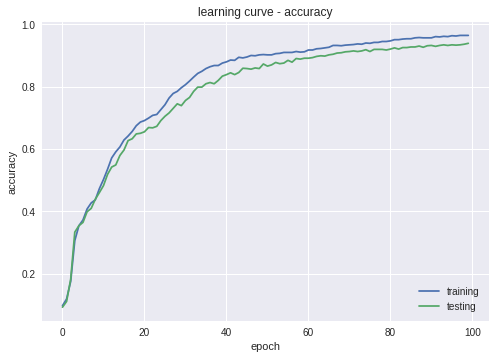

In [15]:
#training and testing acuracy
plt.plot(history_vgg3.history['acc'])
plt.plot(history_vgg3.history['val_acc'])
plt.title('learning curve - accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'testing'], loc='lower right')
plt.show()

With the new optimizer sgd, the model is learning and its performance is very good. I think adam optimizer didn't work because I didn't set the appropriate learning rate.

It's worth mentioning that it takes longer to train the VGG16 model when I re-train more layers. If I only train dense-layers, the model converge with 20 epochs. However, with the upmost conv layers being re-trained, the model didn't converge even at 100 epochs.

I think if I set learning rate higher, the epoch required for convergence will be less though.

Seems like VGG16 is a nice model, if I retrain the upmost conv layers, I get the highest accuracy of all models: 93.9% and the model hasn't converged yet, so the accuracy can be higher.

Seems like CNN networks, including VGG16 has better performance than MLP networks. And complex network like VGG16 can have better performance.